Description des entreprises qui divulguent / ne divulguent pas leurs données de gender pay gap

In [9]:
!pip install openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 8.0 MB/s eta 0:00:00


In [37]:
import pandas as pd
import numpy as np
import math
import openpyxl


In [49]:
file_imp_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
imp_data = pd.read_excel(file_imp_path)
imp_data = imp_data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [79]:
data_size = imp_data.shape

print("Size of the DataFrame:")
print("Number of rows:", data_size[0])
print("Number of columns:", data_size[1])

variable_list = imp_data.columns.tolist()
# Display the list of variables
print("List of Variables:")
print(variable_list)

Size of the DataFrame:
Number of rows: 40554
Number of columns: 28
List of Variables:
['company_id', 'year', 'company_name', 'ticker', 'LEI', 'isin', 'Business Desc.', 'region', 'hq_country', 'primary_industry', 'market_cap', 'employees', 'revenue', 'scope_1', 'scope_2', 'scope_3', 'waste_production', 'waste_recycling', 'water_consumption', 'water_withdrawal', 'energy_consumption', 'hours_of_training', 'independent_board_members_percentage', 'legal_costs_paid_for_controversies', 'ceo_compensation', 'gender_pay_gap', 'secteur', 'missing']


In [54]:
imp_data['missing'] = imp_data['gender_pay_gap'].isnull().astype(float)

missing_paygap_subdataset = imp_data[imp_data['missing'] == 1]
non_missing_paygap_subdataset = imp_data[imp_data['missing'] == 0]


data_size = non_missing_paygap_subdataset.shape
#405 observations dans la base non_missing sur 40K 
print("Size of the DataFrame:")
print("Number of rows:", data_size[0])
print("Number of columns:", data_size[1])


Size of the DataFrame:
Number of rows: 405
Number of columns: 28


# Secteurs de prédilection

In [77]:
# Catégorisation en 12 secteurs
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest



# Group by 'secteur' and count occurrences in each dataset
missing_counts = missing_paygap_subdataset['secteur'].value_counts().head(10)
non_missing_counts = non_missing_paygap_subdataset['secteur'].value_counts().head(10)

# Calculate percentages for each dataset
missing_percentages = (missing_counts / missing_counts.sum()) * 100
non_missing_percentages = (non_missing_counts / non_missing_counts.sum()) * 100

# Display the top 10 sectors in each dataset along with their percentages
print("Top 10 Sectors in Missing Pay Gap Subdataset:")
print(missing_counts)

print("\nTop 10 Sectors in Non-Missing Pay Gap Subdataset:")
print(non_missing_counts)

unique_sectors = missing_paygap_subdataset['secteur'].unique()
# Perform Z-tests for each sector
z_test_results = {}
for sector in unique_sectors:
    # Get counts for the current sector in both datasets
    missing_count = missing_paygap_subdataset['secteur'].value_counts()[sector]
    non_missing_count = non_missing_paygap_subdataset['secteur'].value_counts()[sector]
    
    # Total counts in each dataset
    missing_total = len(missing_paygap_subdataset)
    non_missing_total = len(non_missing_paygap_subdataset)
    
    # Perform Z-test
    count = np.array([missing_count, non_missing_count])
    nobs = np.array([missing_total, non_missing_total])
    z_statistic, p_value = proportions_ztest(count, nobs)
    
    # Store results
    z_test_results[sector] = {'z_statistic': z_statistic, 'p_value': p_value}

# Create lists to store significant and nonsignificant sectors
significant_sectors = []
nonsignificant_sectors = []

# Assuming 'z_test_results' is your dictionary containing z-test results for each sector

# Iterate over z-test results
for sector, results in z_test_results.items():
    if results['p_value'] < 0.05:  # Significant at 5% threshold
        significant_sectors.append((sector, results['z_statistic'], results['p_value']))
    else:
        nonsignificant_sectors.append((sector, results['z_statistic'], results['p_value']))

# Create DataFrame for significant sectors
significant_df = pd.DataFrame(significant_sectors, columns=['Sector', 'Z-statistic', 'p-value'])
significant_df['Significance'] = 'Pas de diff signi'

# Create DataFrame for nonsignificant sectors
nonsignificant_df = pd.DataFrame(nonsignificant_sectors, columns=['Sector', 'Z-statistic', 'p-value'])
nonsignificant_df['Significance'] = 'Diff signi'

# Concatenate DataFrames
result_df = pd.concat([significant_df, nonsignificant_df], ignore_index=True)

# Reorder columns
result_df = result_df[[ 'Sector', 'p-value', 'Significance']]

# Display the result in a table
print(result_df)


# Je ne sais pas vraiment si on peut conclure sur une différence notable de "types de secteurs" 
# Peut etre légèrement plus de services dans les Non-missing pay gap (entreprises qui révèlent leur différence de salaire)
# On note cependnant que cette différence n'est pas siginificative pour 4/12 secteurs


Top 10 Sectors in Missing Pay Gap Subdataset:
secteur
Information Technology                        5175
Industrials, capital goods                    5065
Materials                                     4659
Consumer Discretionary                        4394
Financials                                    4392
Health Care                                   3921
Consumer Staples                              3398
Industrials, commercial and transportation    3069
Communication Services                        1767
Real Estate                                   1578
Name: count, dtype: int64

Top 10 Sectors in Non-Missing Pay Gap Subdataset:
secteur
Consumer Discretionary                        46
Financials                                    42
Consumer Staples                              40
Information Technology                        39
Industrials, commercial and transportation    39
Utilities                                     38
Materials                                     36
Industri

 # Biais de taille (seules grosses entreprises divulguent) ?


In [122]:
from scipy.stats import ttest_ind
import statsmodels.api as sm

# Perform independent two-sample t-test for 'employees'
ttest_employees_stat, ttest_employees_pval = ttest_ind(missing_paygap_subdataset['employees'], non_missing_paygap_subdataset['employees'], nan_policy='omit')

# Perform independent two-sample t-test for 'revenue'
ttest_revenue_stat, ttest_revenue_pval = ttest_ind(missing_paygap_subdataset['revenue'], non_missing_paygap_subdataset['revenue'], nan_policy='omit')

# Print results
print("Independent Two-Sample T-test for Employees:")
print("Statistic:", ttest_employees_stat)
print("p-value:", ttest_employees_pval)

print("\nIndependent Two-Sample T-test for Revenue:")
print("Statistic:", ttest_revenue_stat)
print("p-value:", ttest_revenue_pval)


# Différence significative sur les deux aspects mais est ce que cela s'explique par des différences de composition
# sectorielle?

import pandas as pd
from scipy.stats import ttest_ind

# Assuming 'missing_paygap_subdataset' and 'non_missing_paygap_subdataset' are your subdatasets

# Create a function to calculate the mean and perform t-test for each sector
def calculate_sector_statistics(data1, data2, variable):
    sector_statistics = []
    sectors = data1['secteur'].unique()
    for sector in sectors:
        # Subset data for the current sector
        sector_data1 = data1[data1['secteur'] == sector][variable]
        sector_data2 = data2[data2['secteur'] == sector][variable]
        
        # Calculate mean for each database
        mean1 = sector_data1.mean()
        mean2 = sector_data2.mean()
        
        # Perform t-test
        _, p_value = ttest_ind(sector_data1, sector_data2, nan_policy='omit')
        
        # Append results
        sector_statistics.append((sector, mean1, mean2, p_value))
    
    # Create DataFrame
    df = pd.DataFrame(sector_statistics, columns=['Sector', f'{variable}_Mean_Missing', f'{variable}_Mean_Non_Missing', 'p-value'])
    
    return df

# Calculate statistics for 'employees' variable
employees_statistics = calculate_sector_statistics(missing_paygap_subdataset, non_missing_paygap_subdataset, 'employees')

# Calculate statistics for 'revenue' variable
revenue_statistics = calculate_sector_statistics(missing_paygap_subdataset, non_missing_paygap_subdataset, 'revenue')

# Merge statistics for 'employees' and 'revenue' into a single DataFrame
combined_statistics = pd.merge(employees_statistics, revenue_statistics, on='Sector')

# Print the combined statistics
print("Statistics per Sector:")
print(combined_statistics)

# Pas de diff sectorielle, la taille est systématiquement significativement plus elevé dans le cas des non-misisng
# Cela peut peut etre s'expliquer par une legislation plus contraignante sur la divulgation s'appliquant aux grandes
# entreprises



X = sm.add_constant(imp_data[['revenue', 'employees','market_cap']])
y = imp_data['missing']

# Fit logistic regression model
model = sm.OLS(y, X, missing='drop' ).fit()
# Print regression summary
print(model.summary())

# je voulais retrouver un grand R^2 dans la reg d'être missing sur ces deux paramètre de taille
# mais ce n'est pas vraiment le cas -> 0.004
# correlation tout de meme significative et négative entre les deux ( + on est grand (en nb employés notammen) - on divulgue)

Independent Two-Sample T-test for Employees:
Statistic: -8.939555655503472
p-value: 4.107188460805222e-19

Independent Two-Sample T-test for Revenue:
Statistic: -12.495354226784364
p-value: 9.24655422201162e-36
Statistics per Sector:
                                        Sector  employees_Mean_Missing  \
0                       Information Technology            11210.457915   
1                                       Energy            10534.421466   
2                       Communication Services            13146.885734   
3                             Consumer Staples            22132.393372   
4                       Consumer Discretionary            18886.837800   
5                                   Financials            13946.290548   
6                                  Health Care             8258.747093   
7   Industrials, commercial and transportation            15416.456404   
8                   Industrials, capital goods            12550.947952   
9                         

In [134]:
X = imp_data[['revenue', 'employees', 'market_cap', 'region','secteur']]
X = pd.get_dummies(X, columns=['region','secteur'], drop_first=True)
# Convert variables starting with "region" to integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')]
X[region_columns] = X[region_columns].astype(int)
# Add constant to independent variables
X = sm.add_constant(X)
y = imp_data['missing']

# Fit logisic regression model
model = sm.OLS(y, X,missing ="drop").fit()

# Print regression summary
print(model.summary())

# Gain très marginal de pouvoir predictif en ajoutant région et secteur 


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     81.23
Date:                Tue, 26 Mar 2024   Prob (F-statistic):          3.71e-293
Time:                        17:30:39   Log-Likelihood:                 26431.
No. Observations:               32695   AIC:                        -5.282e+04
Df Residuals:                   32676   BIC:                        -5.266e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

# Bons/mauvais élèves sur les autres variables d'intérêt en controlant du secteur, de la région, de la taille ?

/opt/mamba/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


                            OLS Regression Results                            
Dep. Variable:                missing   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     2.232
Date:                Tue, 26 Mar 2024   Prob (F-statistic):             0.0589
Time:                        17:52:31   Log-Likelihood:                 10.733
No. Observations:                  32   AIC:                             8.534
Df Residuals:                      17   BIC:                             30.52
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

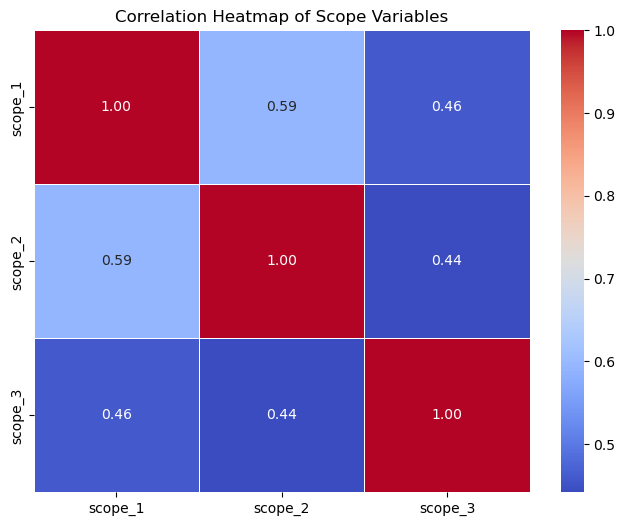

In [157]:
# varia sociales potentiellement reliées : 
# Hours of training per employee 
# ceo compensation

# varia ecolo potentiellement reliées :
# scope 1/2/3



X = imp_data[['hours_of_training','ceo_compensation','scope_1','scope_2',
              'scope_3','revenue', 'employees', 'market_cap','region','secteur']]

"""
log_columns = []
for column in reg_columns:
    # Check if column is numerical and not 'region' or 'secteur'
    if np.issubdtype(imp_data[column].dtype, np.number) and column not in ['region', 'secteur']:
        # Apply logarithmic transformation
        imp_data[column] = np.log(imp_data[column])
        # Add column name to log_columns list
        log_columns.append(column)
"""


# Select relevant columns
# X = imp_data[['region', 'secteur'] + reg_columns]

X = pd.get_dummies(X, columns=['region','secteur'], drop_first=True)
# Convert variables starting with "region" to integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')]


X[region_columns] = X[region_columns].astype(int)
# Add constant to independent variables
X = sm.add_constant(X)
y = imp_data['missing']

# Fit logisic regression model
model = sm.OLS(y, X,missing ="drop").fit()

# Print regression summary
print(model.summary())

# Scope 3 semble avoir un coefficient proche de la significativité pour expliquer (attention, les scope étant
# potentiellement fortement correlés, peut etre que scope 1 ou 2 expliquent tout autant)

# region_Asia / Pacific  0.2436 / secteur_Consumer Discretionary   0.1079  -> Très grand coef pour region/secteur 
# par rapport à avant, ca parait assez bizarre


scope_columns = ['scope_1', 'scope_2', 'scope_3']

# Calculate the correlation matrix
correlation_matrix = imp_data[scope_columns].corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Scope Variables')
plt.show()

# Correlation forte mais pas de 1 entre les 3 scopes !! Fouiller le scope 3

Analyse en composante principales (ACP) pour faire ressortir les principales variables discriminantes ?

In [182]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Selecting relevant features for PCA
X = missing_paygap_subdataset[['region', 'hq_country', 'market_cap', 'employees', 'revenue', 'scope_1', 'scope_2', 'scope_3',
                     'waste_production', 'waste_recycling', 'water_consumption', 'water_withdrawal', 
                     'energy_consumption', 'hours_of_training', 'independent_board_members_percentage', 
                     'legal_costs_paid_for_controversies', 'ceo_compensation', 'gender_pay_gap', 
                     'secteur']]

# Dropping rows with missing values
X.dropna(inplace=True)

# Checking for infinite values (NaN, inf, -inf) and handling them
infinite_values = X[X.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
if not infinite_values.empty:
    print("Warning: Infinite or NaN values detected and removed.")
    X = X[~X.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Converting categorical variables to dummy variables
X = pd.get_dummies(X, columns=['region', 'hq_country', 'secteur'], drop_first=True)

# Ensuring that categorical variables are encoded as integers
region_columns = [col for col in X.columns if col.startswith('region') or col.startswith('secteur')
                 or col.startswith('hq_country')]
X[region_columns] = X[region_columns].astype(int)

# Scaling the data using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Performing PCA
pca = PCA()
pca.fit(X_scaled)

# Plotting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

# Interpreting principal components
loading_vectors = pca.components_[0]
print("Loading Vectors for PC1:")
print(pd.DataFrame({'Variable': X.columns, 'Loading': loading_vectors}))

Empty DataFrame
Columns: [market_cap, employees, revenue, scope_1, scope_2, scope_3, waste_production, waste_recycling, water_consumption, water_withdrawal, energy_consumption, hours_of_training, independent_board_members_percentage, legal_costs_paid_for_controversies, ceo_compensation, gender_pay_gap]
Index: []


/tmp/ipykernel_366/3544881579.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by MinMaxScaler.